In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:

IMAGE_SIZE=256
BATCH_SIZE=10
channels=3
epochs = 100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
'Data',shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)

Found 119 files belonging to 3 classes.


# Step 1: Load and Preprocess the Data

In [4]:
#class names
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [5]:
#total batches
len(dataset)


12

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())


(10, 256, 256, 3)
[0 2 2 2 0 1 0 2 0 2]


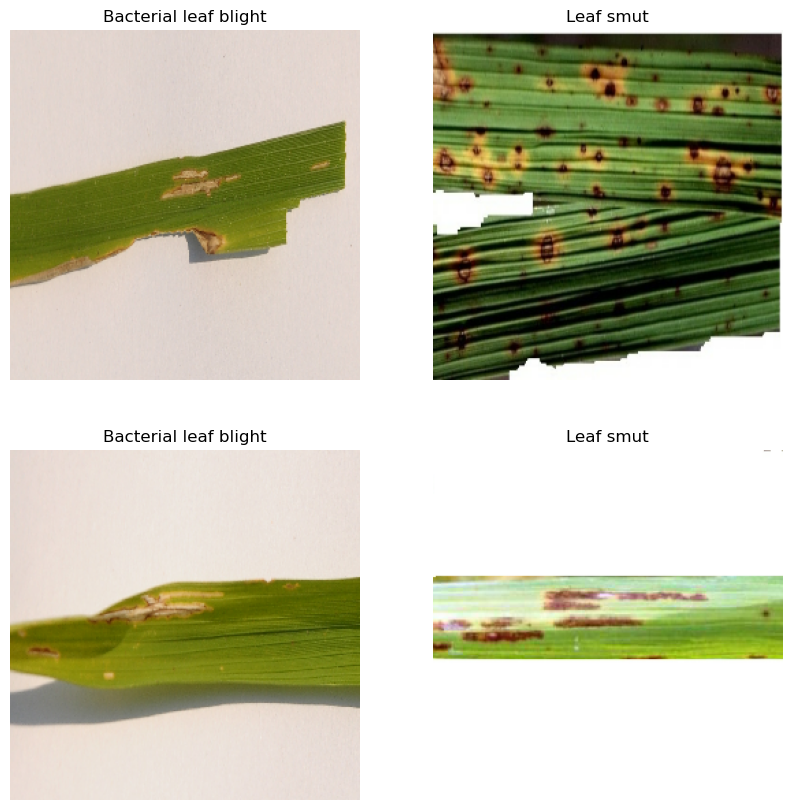

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')


In [8]:
def get_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = 8
    val_size = 2
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds


In [9]:
train_ds,val_ds,test_ds = get_partition_tf(dataset)

In [10]:
len(test_ds)

2

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [14]:
#preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


In [15]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [16]:
# Applying Data Augmentation on train dataset

train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [18]:
#architecture
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (10, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (10, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (10, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (10, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (10, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (10, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (10, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (10, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (10, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (10, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (10, 12, 12, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (10, 6, 6, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (10, 1152)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (10, 64)                    │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (10, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185,699 (725.39 KB)

 Trainable params: 185,699 (725.39 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(train_ds,epochs=epochs,batch_size=BATCH_SIZE,verbose=1,
         validation_data=val_ds)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 717ms/step - accuracy: 0.3023 - loss: 1.1165 - val_accuracy: 0.3500 - val_loss: 1.1025
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 482ms/step - accuracy: 0.3410 - loss: 1.0981 - val_accuracy: 0.3000 - val_loss: 1.1151
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 484ms/step - accuracy: 0.3701 - loss: 1.0975 - val_accuracy: 0.3000 - val_loss: 1.1107
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - accuracy: 0.3758 - loss: 1.0891 - val_accuracy: 0.2500 - val_loss: 1.1067
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step - accuracy: 0.3817 - loss: 1.0849 - val_accuracy: 0.3000 - val_loss: 1.1104
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 487ms/step - accuracy: 0.4070 - loss: 1.0744 - val_accuracy: 0.3000 - val_loss: 1.1164
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 495ms/step - accuracy: 0.3312 - loss: 1.0987 - val_accuracy: 0.4000 - val_loss: 1.0988
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - accuracy: 0.4134 - loss: 1.0749 - val_accuracy: 0.4500 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 480ms/step - accuracy: 0.7867 - loss: 0.5093 - val_accuracy: 0.6500 - val_loss: 0.5527
Epoch 52/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - accuracy: 0.7809 - loss: 0.4686 - val_accuracy: 0.8000 - val_loss: 0.4570
Epoch 53/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - accuracy: 0.8831 - loss: 0.3751 - val_accuracy: 0.7000 - val_loss: 0.5396
Epoch 54/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 482ms/step - accuracy: 0.9287 - loss: 0.3000 - val_accuracy: 0.7500 - val_loss: 0.4497
Epoch 55/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 477ms/step - accuracy: 0.8485 - loss: 0.3270 - val_accuracy: 0.8000 - val_loss: 0.5414
Epoch 56/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 491ms/step - accuracy: 0.8956 - loss: 0.2916 - val_accuracy: 0.7500 - val_loss: 0.5026
Epoch 57/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 469ms/step - accuracy: 0.8593 - loss: 0.3259 - val_accuracy: 0.7000 - val_loss: 0.6789
Epoch 58/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 475ms/step - accuracy: 0.8581 - loss: 0.3279 - val_accuracy: 0.7000 - val_lo

In [21]:
score = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.8667 - loss: 0.7600


In [22]:
score

[0.5912522077560425, 0.8999999761581421]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 8}

In [25]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

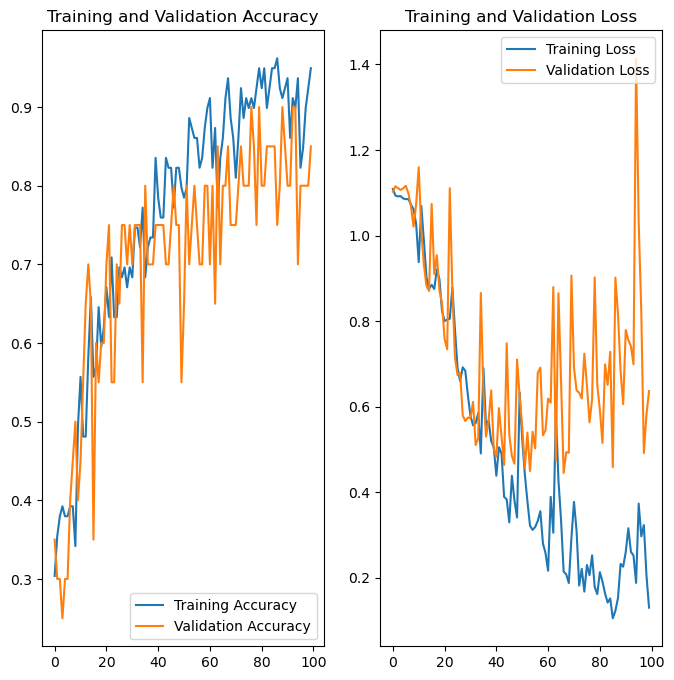

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Bacterial leaf blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
predicted label: Bacterial leaf blight


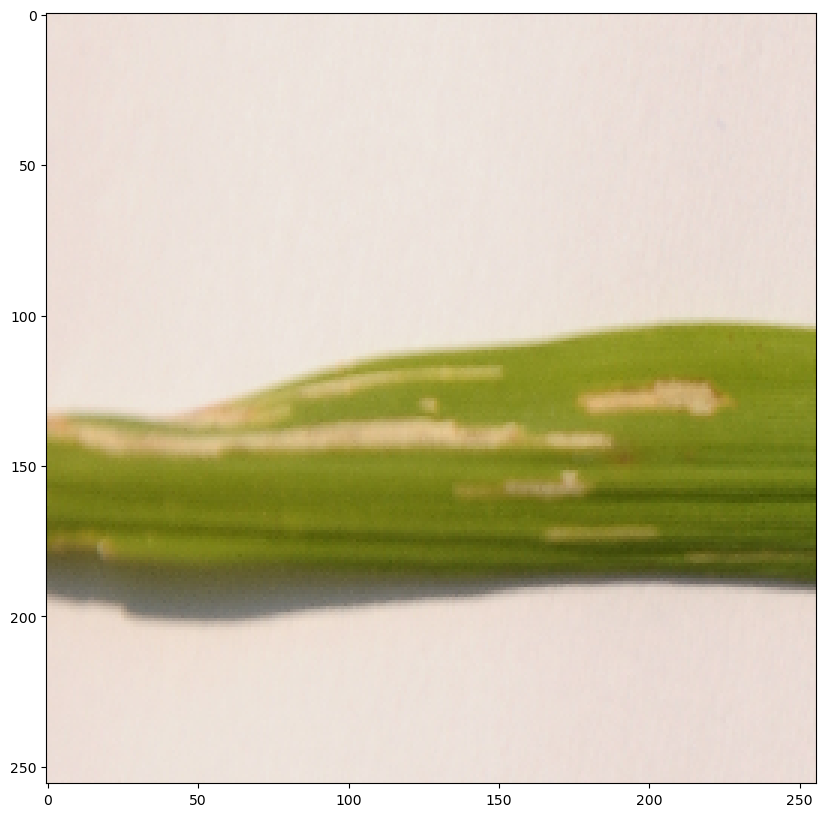

In [27]:
#prediction on sample
plt.figure(figsize=(10,10))
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


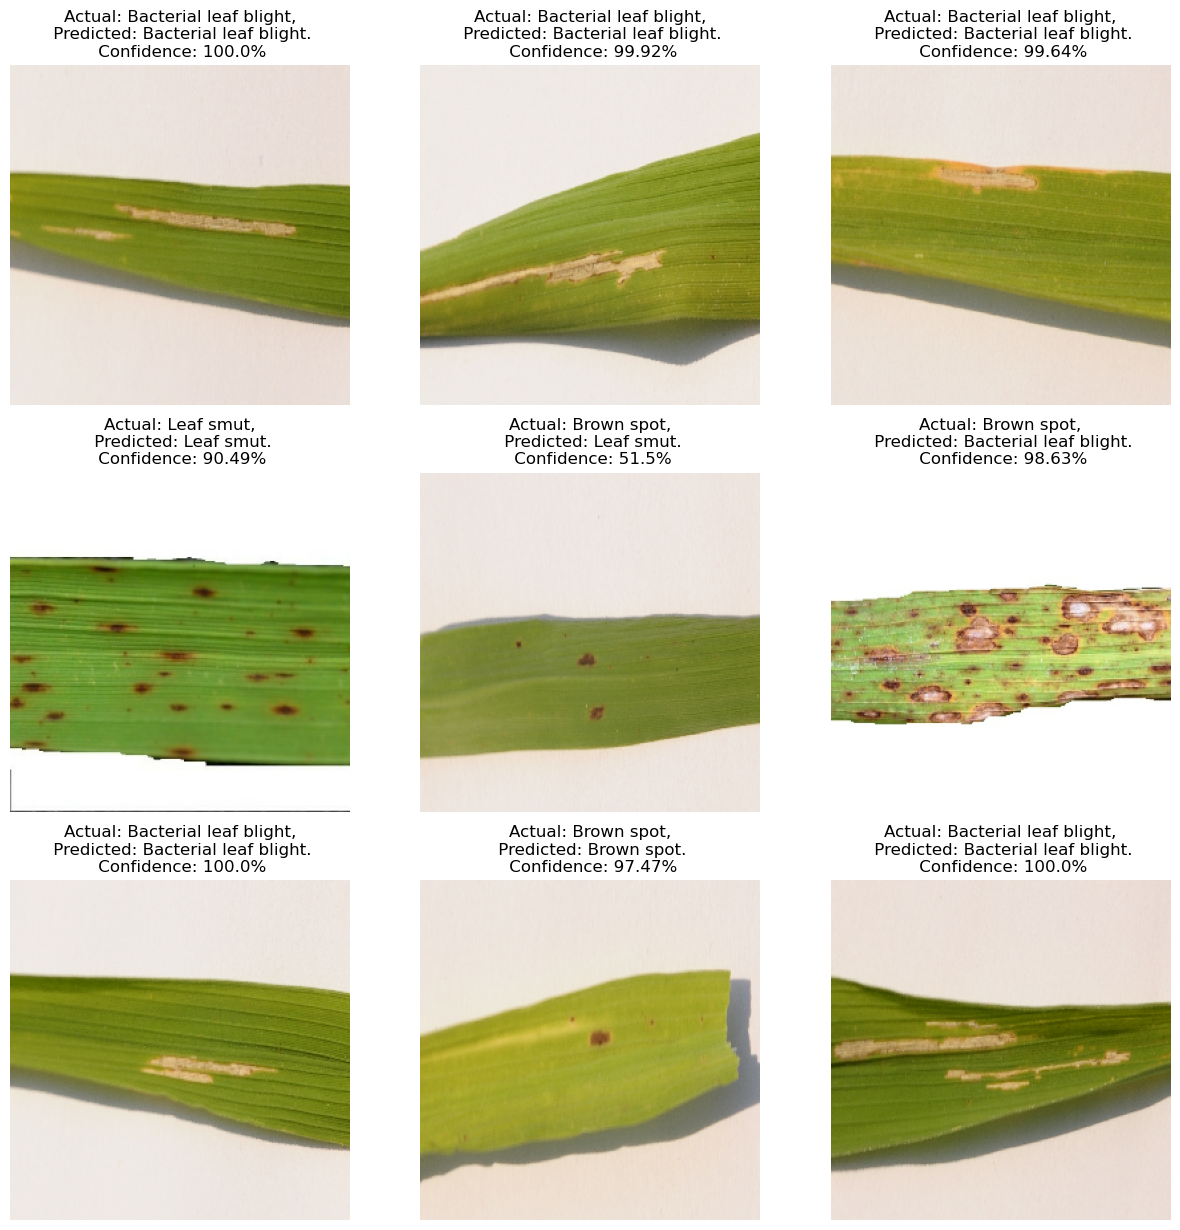

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")